In [1]:
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Tuple
import json
import numpy as np
import torch
from tqdm import tqdm
import cv2

from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [2]:
@dataclass
class DataUnit:
    image: str
    caption: str
    mask: Tuple[str, int]  # (image, index), where mask = image == index
    prev_image: str
    prev_mask: Tuple[str, int]
    
    def __post_init__(self):
        self.image = str(self.image)
        self.mask = (str(self.mask[0]), int(self.mask[1]))
        self.prev_image = str(self.prev_image)
        self.prev_mask = (str(self.prev_mask[0]), int(self.prev_mask[1]))

### Data Loading

In [3]:
def red_caption(filename):
    filename = Path(filename)
    caption_file = filename.parents[1] / "caption" / filename.with_suffix(".txt").name
    if not caption_file.exists():
        return None
    with open(caption_file, "r") as f:
        caption = f.read()
    return caption


def is_adjacent_frames(image1, image2) -> bool:
    diff = image1.astype(float) - image2.astype(float)
    thresholds = np.asarray([15, 30, 50])
    diffs = np.percentile(np.abs(diff), [50, 75, 85])
    return np.all(diffs < thresholds)


def is_valid_mask(mask1, mask2, idx, min_threshold=0.05, max_threshold=0.3) -> bool:
    image_size = mask1.shape[0] * mask1.shape[1]
    area1 = (mask1 == idx).sum()
    area2 = (mask2 == idx).sum()
    return (
        min_threshold < area1 / image_size < max_threshold
        and min_threshold < area2 / image_size < max_threshold
    )


def enlarge_mask(mask, index, kscale=0.05):
    mask = (mask == index).astype(np.uint8) * 255
    if kscale <= 0:
        return mask
    a = max(int(np.sqrt(mask.shape[0] * mask.shape[1]) * kscale), 11)
    return cv2.dilate(mask, np.ones((a, a), np.uint8))

### Rules of data collection
1. Videos with masks and captions
2. Two frames |t1 - t2| <= 2
3. Two frames |I1 -I2| < x
4. Two frames All(area(Mask_i) >= 0.05*Image_size)

In [4]:
src_dir = Path("/data/video-dataset/VSPW/")
with open(src_dir / "label_num_dic_final.json", "r") as f:
    label2idx = json.load(f)
idx2label = {idx: label for label, idx in label2idx.items()}
videos = sorted(src_dir.glob("data/*"))

validations = {"415_5FjFtNEBX2I", "371_xpPeyi-vFDc"}



In [5]:
def create_dataset(video_dir: Path):
    cache = {}

    def read_image(filename):
        if filename not in cache:
            cache[filename] = np.array(Image.open(filename))
        return cache[filename]

    if video_dir.stem in validations:
        return []
    if not (video_dir / "mask").exists() or not (video_dir / "caption").exists():
        return []
    frames = sorted((video_dir / "origin").glob("*.jpg"))
    n_frames = len(frames)
    pairs = list(zip(range(0, n_frames - 1), range(1, n_frames))) + list(
        zip(range(0, n_frames - 2), range(2, n_frames))
    )
    dataset = []
    for i, j in pairs:
        image_i, image_j = frames[i], frames[j]
        mask_i, mask_j = (
            video_dir / "mask" / f"{image_i.stem}.png",
            video_dir / "mask" / f"{image_j.stem}.png",
        )
        caption_i, caption_j = red_caption(image_i), red_caption(image_j)
        if not mask_i.exists() or not mask_j.exists() or not caption_i or not caption_j:
            continue
        if not is_adjacent_frames(read_image(image_i), read_image(image_j)):
            continue

        mask_i_img = read_image(mask_i)
        mask_j_img = read_image(mask_j)
        mask_ids = set(np.unique(mask_i_img)) & set(np.unique(mask_j_img))
        for idx in mask_ids:
            if not is_valid_mask(mask_i_img, mask_j_img, idx):
                continue
            data_unit = DataUnit(
                image=frames[j],
                caption=caption_j,
                mask=(mask_j, idx),
                prev_image=frames[i],
                prev_mask=(mask_i, idx),
            )
            dataset.append(data_unit)
    return dataset

In [6]:
from multiprocessing import Pool

pool = Pool(12)
dataset = []
for subset in tqdm(pool.imap_unordered(create_dataset, videos), total=len(videos)):
    dataset += subset
pool.close()
pool.join()

100%|██████████| 3536/3536 [24:05<00:00,  2.45it/s] 


In [12]:
with open(src_dir / "data.jsonl", "w") as f:
    for data_unit in dataset:
        data_unit.mask = (data_unit.mask[0], int(data_unit.mask[1]))
        data_unit.prev_mask = (data_unit.prev_mask[0], int(data_unit.prev_mask[1]))
        f.write(json.dumps(asdict(data_unit)) + "\n")

### Copy a validation set

In [5]:
import shutil

# temporally create a validation sample
video_dir = src_dir / "data" / "371_xpPeyi-vFDc"
dest_dir = Path("/home/longc/data/code/lora-scripts/config/video-example-2")

images = sorted(video_dir.glob("origin/*"))
masks = sorted(video_dir.glob("mask/*"))


In [6]:
mask = np.array(Image.open(masks[0]))

In [11]:
for idx in np.unique(mask):
    print(idx, idx2label.get(str(idx)))

1 wall
9 window
14 floor
46 cushion_or_carpet
77 box
85 bottle_or_cup
90 table_or_desk
91 chair_or_seat
94 shelf
105 textiles
115 screen_or_television
116 computer
119 keyboard
120 other_electronic_product
255 None


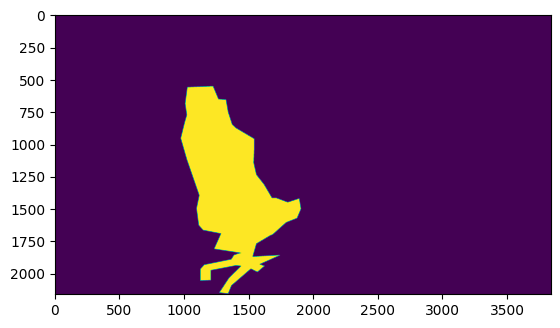

In [12]:
plt.imshow(mask==91)

In [14]:
for image, mask in tqdm(zip(images, masks), total=len(images)):
    dest_image = dest_dir / "images" / image.name
    dest_mask = dest_dir / "masks" / mask.name
    dest_image.parent.mkdir(parents=True, exist_ok=True)
    dest_mask.parent.mkdir(parents=True, exist_ok=True)
    shutil.copyfile(image, dest_image)
    
    mask = enlarge_mask(np.array(Image.open(mask)), index=91, kscale=0)  # bottle_or_cup
    cv2.imwrite(str(dest_mask), mask)

100%|██████████| 45/45 [00:00<00:00, 59.49it/s]
